In [34]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier


In [35]:
df = pd.read_csv("data.csv")
df.head()


,tweet_text,cyberbullying_type
0,The quality is superb and very satisfying,1
1,This is terrible and a complete waste of time,0
2,"Absolutely fantastic outcome, highly recommended",1
3,The product broke and is extremely poor quality,0
4,I am extremely happy with the results,1


In [36]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [37]:
df.dtypes

tweet_text            object
cyberbullying_type     int64
dtype: object

In [38]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [39]:
df.cyberbullying_type.value_counts()


1    500
0    500
Name: cyberbullying_type, dtype: int64

In [40]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    return text.lower()

df["clean_text"] = df["tweet_text"].apply(clean_text)


In [41]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["cyberbullying_type"])


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)


In [43]:
bert = SentenceTransformer('all-MiniLM-L6-v2')


In [44]:
X_train_emb = bert.encode(X_train.tolist())
X_test_emb = bert.encode(X_test.tolist())


In [45]:
model_lr = LogisticRegression(max_iter=3000)
model_svm = LinearSVC()


In [47]:
estimators = [
    ('lr', model_lr),
    ('svm', model_svm)
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=GradientBoostingClassifier(),
    n_jobs=-1
)
stack.fit(X_train_emb, y_train)
y_pred = stack.predict(X_test_emb)
print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=["notbullying", "bullying"]))



cm = confusion_matrix(y_test, y_pred)
cm


Accuracy: 1.0
              precision    recall  f1-score   support

 notbullying       1.00      1.00      1.00       100
    bullying       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



array([[100,   0],
       [  0, 100]], dtype=int64)

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np


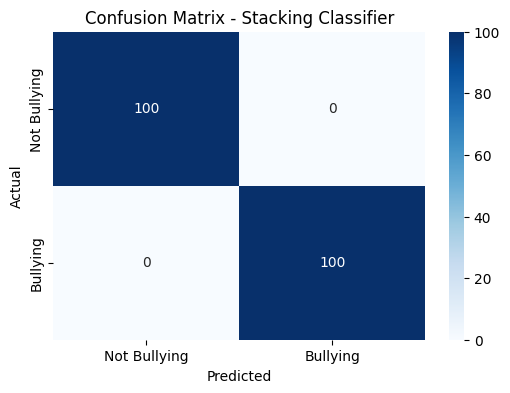

In [57]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Not Bullying", "Bullying"], yticklabels=["Not Bullying", "Bullying"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacking Classifier")
plt.show()


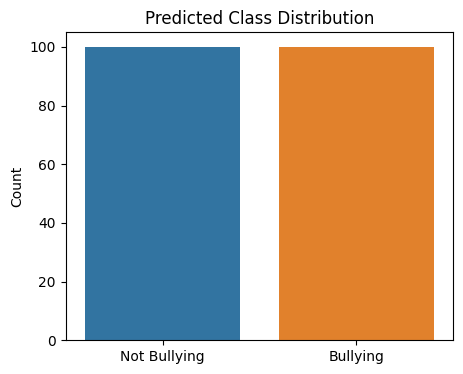

In [59]:
unique, counts = np.unique(y_pred, return_counts=True)
labels = ["Not Bullying", "Bullying"]

plt.figure(figsize=(5,4))
sns.barplot(x=labels, y=counts)
plt.title("Predicted Class Distribution")
plt.ylabel("Count")
plt.show()


In [49]:
import joblib

joblib.dump(stack, "hybrid_cyberbullying_model.pkl")



['hybrid_cyberbullying_model.pkl']

In [50]:
bert.save("bert_embeddings_model")


In [55]:
from sentence_transformers import SentenceTransformer
import joblib

# Load BERT sentence embedding model
bert = SentenceTransformer('all-MiniLM-L6-v2')

# Load your saved stacking model
model = joblib.load("hybrid_cyberbullying_model.pkl")

def predict_text(text):
    # Convert text into BERT embedding (2D array)
    X = bert.encode([text])
    
    # Predict
    pred = model.predict(X)[0]
    prob = model.predict_proba(X)[0]

    label = "bullying" if pred == 0 else "notbullying"

    print("INPUT:", text)
    print("PREDICTION:", label)
    print("CONFIDENCE:", round(max(prob) * 100, 2), "%")

# Test
predict_text("You are good")
predict_text("You look beautiful today")


INPUT: You are good
PREDICTION: notbullying
CONFIDENCE: 100.0 %
INPUT: You look beautiful today
PREDICTION: notbullying
CONFIDENCE: 100.0 %
